In [6]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import cv2
import pathlib
from pyometiff import OMETIFFReader
import imageio as io
from __future__ import print_function
import scanpy as sc
import os
import pandas as pd
import PIL
from tqdm.notebook import tqdm

#### This script is an example in which we aligned day 8 IF scanning with day 8 Xenium DAPI

Enter the path to the IF OME TiFF and the Xenium output folder

In [7]:
path_to_IF_ome = '/projects/2023_Spatial_Paper/data/IF_timecourse/OMETIFF/D8_SI_r2_IF.ome.tif'
xenium_path = '/mnt/sata1/Analysis_Alex/timecourse_replicates/day8_SI_r2/xenium_output'

In [8]:
img_array_IF_orig = io.imread_v2(path_to_IF_ome)

### Downsizing both the IF DAPI and the Xenium DAPI image

In [9]:
channel_display = 0
down_factor = 10

new_width = int(img_array_IF_orig.shape[1] / down_factor)
new_height = int(img_array_IF_orig.shape[2] / down_factor)
# Normalize the image to the range [0, 1]
normalized_image = img_array_IF_orig[channel_display, :, :] / np.max(img_array_IF_orig[channel_display, :,:])

# Scale the values back to the range [0, 255] and convert to uint8
normalized_image = (normalized_image * 255).astype(np.uint8)

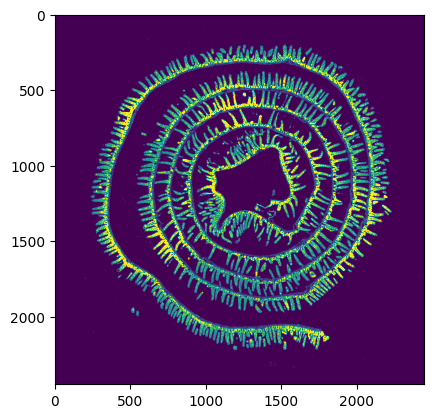

In [10]:
# Resize the image
thumbnail = cv2.resize(normalized_image, (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

In [11]:

img_array_IF = normalized_image
downscale_factor_IF = 3

pad_height = (downscale_factor_IF - img_array_IF.shape[0] % downscale_factor_IF) % downscale_factor_IF
pad_width = (downscale_factor_IF - img_array_IF.shape[1] % downscale_factor_IF) % downscale_factor_IF

# Pad the array with zeros
padded_IF = np.pad(img_array_IF, ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_IF.shape[1] / downscale_factor_IF)
new_height = int(padded_IF.shape[0] / downscale_factor_IF)

# Resize the image
resized_image = cv2.resize(padded_IF, (new_width, new_height))
IF_image = resized_image

In [12]:

img_fpath = pathlib.Path(os.path.join(xenium_path, 'morphology_mip.ome.tif'))

reader = OMETIFFReader(fpath=img_fpath)

img_array_xenium, metadata_xenium, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


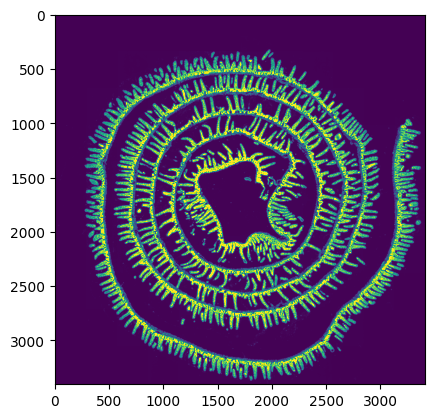

In [13]:
down_factor = 10

new_width = int(img_array_xenium.shape[1] / down_factor)
new_height = int(img_array_xenium.shape[0] / down_factor)

# Resize the image
thumbnail = cv2.resize(img_array_xenium, (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

In [14]:
downscale_factor = 3
# Calculate the amount of padding needed for each axis
pad_height = (downscale_factor - img_array_xenium.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_xenium.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_array = np.pad(img_array_xenium, ((0, pad_height), (0, pad_width)), mode='constant')

# Now 'padded_array' will have both axes sizes divisible by 2
img_array_xenium = padded_array

new_width = int(img_array_xenium.shape[1] /downscale_factor) 
new_height = int(img_array_xenium.shape[0] / downscale_factor)

# Resize the image
resized_xenium = cv2.resize(img_array_xenium, (new_width, new_height))


#### Finding keypoint matches between both of the downsized versions and display the alignment between the two images

In [15]:
#max number of corners to detect in each image
MAX_FEATURES = 4000
#percent of corner patches to keep
GOOD_MATCH_PERCENT = 0.5
#how much to blur the initial images to capture villi structure keypoints
blur_res_IF = (1, 1)
blur_res_xen = (1, 1)


def alignImages(im1, im2):

    print('keypoint detection...')
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    print('feature matching...')
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    print(len(matches))
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    print('prune bad matches...')
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    print(len(matches))
    # Draw top matches
    # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # plt.figure(dpi=200)
    # plt.imshow(imMatches)
    # plt.show()
    # cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(cv2.blur(((resized_image/np.max(resized_image))*255).astype(np.uint8), blur_res_IF), cv2.blur(((resized_xenium/np.max(resized_xenium))*255).astype(np.uint8), blur_res_xen))

# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
Estimated homography : 
 [[ 7.83780509e-03  1.52785488e+00 -1.51941323e+02]
 [-1.52942054e+00  8.77295328e-03  1.24108000e+04]
 [-1.21113491e-07 -1.23512927e-08  1.00000000e+00]]


In [16]:
height, width = resized_xenium.shape
im1Reg = cv2.warpPerspective(resized_image, h, (width, height))

new_width = int(im1Reg.shape[1] *downscale_factor_IF) 
new_height = int(im1Reg.shape[0] *downscale_factor_IF)

# Resize the image
warped = cv2.resize(im1Reg, (new_width, new_height))

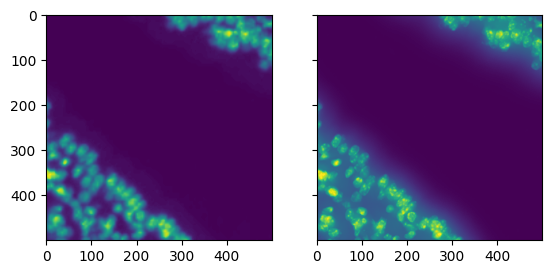

In [18]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(warped[10000:10500, 10000:10500])
ax2.imshow(img_array_xenium[10000:10500, 10000:10500])
plt.show()
#downsize for diplay before this
# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# ax1.imshow(warped)
# ax2.imshow(img_array_xenium)
# plt.show()

### Aligning high quality IF with low quality aligned IF

In [19]:

img_array_HE2 = normalized_image
downscale_factor = 1

pad_height = (downscale_factor - img_array_HE2.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_HE2.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_HE2 = np.pad(img_array_HE2, ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_HE2.shape[1] / downscale_factor)
new_height = int(padded_HE2.shape[0] / downscale_factor)

# Resize the image
resized_image2 = cv2.resize(padded_HE2, (new_width, new_height))
HE_image2 = resized_image2

In [20]:
downscale_factor = 2
# Calculate the amount of padding needed for each axis
pad_height = (downscale_factor - warped.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - warped.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_array = np.pad(warped, ((0, pad_height), (0, pad_width)), mode='constant')

# Now 'padded_array' will have both axes sizes divisible by 2
warped = padded_array

new_width = int(warped.shape[1] /downscale_factor) 
new_height = int(warped.shape[0] / downscale_factor)

# Resize the image
resized_warped = cv2.resize(warped, (new_width, new_height))


In [21]:
#max number of corners to detect in each image
MAX_FEATURES = 4000
#percent of corner patches to keep
GOOD_MATCH_PERCENT = 0.5
#how much to blur the initial images to capture villi structure keypoints
blur_res = (5, 5)


def alignImages(im1, im2):

    print('keypoint detection...')
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    print('feature matching...')
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    print(len(matches))
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    print('prune bad matches...')
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    print(len(matches))
    # Draw top matches
    # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # plt.figure(dpi=200)
    # plt.imshow(imMatches)
    # plt.show()
    #cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    print('warping')
    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(cv2.blur(((resized_image2/np.max(resized_image2))*255).astype(np.uint8), blur_res)[:32766, :32766], resized_warped)

# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
warping
Estimated homography : 
 [[ 3.98631361e-03  7.63843573e-01 -2.28593824e+02]
 [-7.64557174e-01  4.21822046e-03  1.86161002e+04]
 [-3.04408228e-08 -1.84798687e-08  1.00000000e+00]]


In [22]:
height, width = warped.shape
im1Reg = cv2.warpPerspective(resized_image2[:32766, :32766], h, (width, height))

new_width = int(im1Reg.shape[1] *downscale_factor) 
new_height = int(im1Reg.shape[0] *downscale_factor)

# Resize the image
warped2 = cv2.resize(im1Reg, (new_width, new_height))

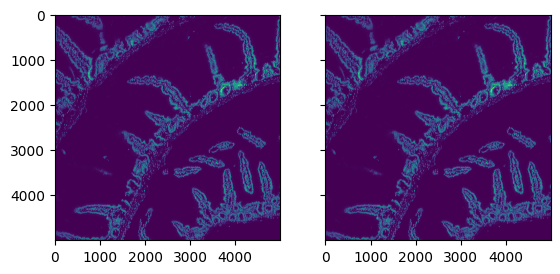

In [23]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(warped2[10000:15000, 10000:15000])
ax2.imshow(warped[10000:15000, 10000:15000])
plt.show()

#### Warp the high quality IF based on the homography matrix

In [24]:
he_stack = []
for i in [0, 1, 2]: 
    try:
        height, width = warped.shape
        im1Reg = cv2.warpPerspective(img_array_IF_orig[i,:,:][:32766, :32766], h, (width, height))

        new_width = int(im1Reg.shape[1] *downscale_factor) 
        new_height = int(im1Reg.shape[0] *downscale_factor)

        # Resize the image
        warped2 = cv2.resize(im1Reg, (new_width, new_height))
        warped_H_and_E = warped2[:np.shape(img_array_xenium)[0], :np.shape(img_array_xenium)[1]]
        he_stack.append(warped_H_and_E)
    except:
        print(f'Channel {i} is not in this image')

In [25]:
transformed_h_and_e = np.dstack(he_stack)

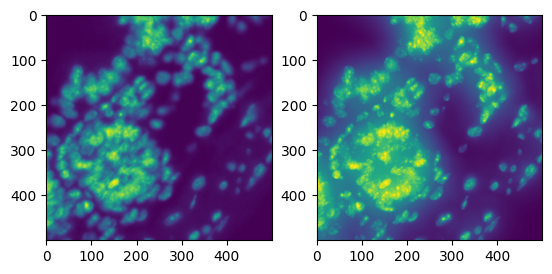

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(transformed_h_and_e[9500:10000, 9500:10000, 0])
ax2.imshow(img_array_xenium[9500:10000, 9500:10000])
plt.show()

In [27]:
np.save(os.path.join(os.path.dirname(xenium_path), 'IF_alignment.npy'), transformed_h_and_e)